# ResNet implementation

#### Configuring the enviroment

In [2]:
# Importing libraries and setting colab environment
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
!brew install graphviz
!pip install torchviz
import torchviz
import sys
drive.mount('/content/drive')
sys.path.append(r'drive/MyDrive/Colab Notebooks/Aprendizado-Profundo/trab1-ResNet-explained')

/bin/bash: line 1: brew: command not found
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-ma

### PyTorch resources used on this project

- torch: The primary module of PyTorch, providing basic operations and serving as the entry point for utilizing other PyTorch modules.
    - torch.device: used to specify the device on which the torch resources will be allocated and executed
    - torch.cuda: Module that provides functions and classes to manage CUDA devices, memory allocation, and data transfer between the CPU and GPU.
        - torch.cuda.is_available: returns a boolean value indicating if a CUDA-enabled GPU is available
        - torch.cuda.amp.GradScaler: This utility is used for mixed-precision training, managing the scaling of the loss function to prevent underflows during backward propagation. It adjusts the scale factor dynamically, which helps in leveraging faster computational speeds on modern GPUs while maintaining the numerical stability of the model.
    - torch.utils:  Provides a variety of utility functions to enhance data loading, batching, and other aspects of model implementation and training.
        - torch.utils.data: This submodule provides classes and functions for working with datasets and data loading in PyTorch.
            - torch.utils.data.DataLoader: Facilitates batch loading of datasets with multi-processing and custom data sampling, significantly streamlining the process of feeding data into models.
            - torch.utils.data.SubsetRandomSampler: Samples elements randomly from a list of provided indices, without replacement

- torchvision: provides a collection of pre-trained models, datasets, and image transformations for computer vision tasks
    - torchvision.transforms: provides common image transformations for data augmentation and preprocessing
        - torchvision.transforms.Compose: create a sequence of transformations to be applied to your data
        - torchvision.transforms.Resize: resizes the input image to the specified size
        - torchvision.transforms.ToTensor: converts a Image to a PyTorch tensor to be operated
        - torchvision.transforms.Normalize: Transforms the input tensor by subtracting the mean and dividing by the standard deviation
    
    - torchvision.datasets: module that provides access to datasets commonly used in computer vision
        - torchvision.datasets.CIFAR10: represents the CIFAR-10 dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. It can perform operations such as loading, transforming, and accessing individual samples.

In [3]:
# Setting global variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Optionally enable mixed precision training
scaler = torch.cuda.amp.GradScaler(enabled=True)
data_path = './data'
num_classes = 10
num_epochs=30

/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [4]:
# Accordingly to this kaggle notebook exploration
# https://www.kaggle.com/code/fanbyprinciple/cifar10-explanation-with-pytorch
# CIFAR10 dataset is composed of 60000 32x32 color images in 10 classes, with 6000 images per class.
# And has a distribution with mean tensor([0.4914, 0.4822, 0.4465]) and std tensor([0.2470, 0.2435, 0.2616]) for each channel
def create_dataloaders(
    data_dir: str,
    batch_size: int=32,
    num_workers: int = 2
):
    normalize = torchvision.transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2470, 0.2435, 0.2616],
    )

    # define transforms
    transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize((112,112)),
            torchvision.transforms.ToTensor(),
            normalize,
    ])

    test_dataset = torchvision.datasets.CIFAR10(
      root=data_dir, train=False,
      download=True, transform=transform,
    )

    train_dataset = torchvision.datasets.CIFAR10(
      root=data_dir, train=True,
      download=True, transform=transform,
    )

    # Create samplers for a 30% subset of the dataset
    num_train = len(train_dataset)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(0.3 * num_train))

    train_idx, _ = indices[:split], indices[split:]

    num_test = len(test_dataset)
    indices = list(range(num_test))
    np.random.shuffle(indices)
    split = int(np.floor(0.3 * num_test))

    test_idx, _ = indices[:split], indices[split:]

    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=True, persistent_workers=True)

    test_dataloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, sampler=test_sampler,
        num_workers=num_workers, pin_memory=True, persistent_workers=True)

    return (train_dataloader, test_dataloader)

In [5]:
train_dataloader, test_dataloader = create_dataloaders(data_dir=data_path, batch_size=32, num_workers=2)

100%|██████████| 170498071/170498071 [00:06<00:00, 27597394.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Train Dataloader:
Image shape: torch.Size([3, 112, 112])
Label: tensor(0)
Image:


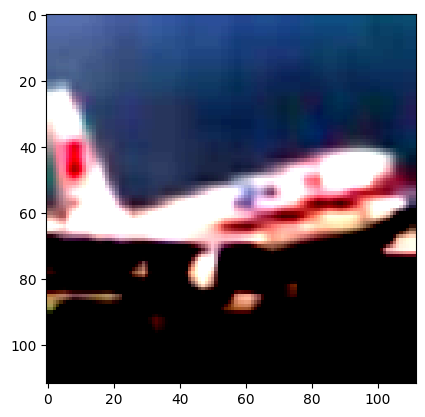

Test Dataloader:
Image shape: torch.Size([3, 112, 112])
Label: tensor(9)
Image:


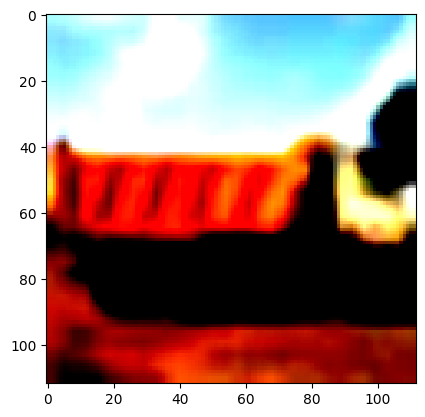

In [8]:
# Print the first image and label for the train dataloader
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
print("Train Dataloader:")
print("Image shape:", images[0].shape)
print("Label:", labels[0])
print("Image:")
plt.imshow(images[0].permute(1, 2, 0))
plt.show()

# Print the first image and label for the test dataloader
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
print("Test Dataloader:")
print("Image shape:", images[0].shape)
print("Label:", labels[0])
print("Image:")
plt.imshow(images[0].permute(1, 2, 0))
plt.show()


- torch.nn:
  - torch.nn.Module: This is the base class for all neural network modules in PyTorch. Your models should also subclass this class.
  - torch.nn.Sequential: This container allows modules to be added in sequence and constructs a network where the output of one module is the input to the next. It simplifies the implementation of models by automatically handling the forward passes through all its modules.
  - torch.nn.Conv2d: This method is used to create a convolutional layer in the neural network which applies a 2D convolution.
  - torch.nn.BatchNorm2d: This method provides a Batch Normalization layer which maintain the mean output close to 0 and the output standard deviation close to 1.
  - torch.nn.ReLU: This is an activation function layer which introduces non-linearities into the model; specifically, it applies the rectified linear unit function element-wise.
  - torch.nn.AdaptiveAvgPool2d: This layer applies an adaptive 2D average pooling over an input signal composed of several input planes, outputting a fixed size that is specified as an argument.
  - torch.nn.Linear: This creates a linear transformation layer with weights and biases.
  - torch.nn.CrossEntropyLoss: This is a loss function commonly used in classification tasks, which combines nn.LogSoftmax() and nn.NLLLoss() in one single class. It is particularly useful for training a classification problem with C classes.
-torch.optim: This module provides various optimization algorithms for building and training neural networks.
  - torch.optim.Adam: This is an optimizer that implements the Adam algorithm, which is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

#### Architecture explanation

- ResNet: This is a class representing the ResNet model, which consists of sequential layers of residual blocks, composed of:
 - BottleneckResidualBlock: This class defines a bottleneck residual block used within ResNet, which helps in building deeper neural networks by reducing the dimensionality at the first convolution, maintaining it at the second, and restoring it at the third.
    - downsample_fn: is designed to match the dimensions of input and output tensors within the ResNet architecture when there is a need for a stride greater than 1 or an increase in the number of channels
 - forward method: Defines how the model processes input data; i.e., it sequentially passes data through all layers defined in the constructor and returns the output.
 - make_layer method: Helper method to create layers of residual blocks with optional downsampling.

In [6]:
class BottleneckResidualBlock(torch.nn.Module):
    expansion = 4

    def __init__(self, in_channels, bottleneck_channels, stride=1, downsample=None):
        super(BottleneckResidualBlock, self).__init__()
        # Save the number of output channels after the final convolution
        self.out_channels = bottleneck_channels * self.expansion

        self.bn1 = torch.nn.BatchNorm2d(in_channels)
        self.conv1 = torch.nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=stride, bias=False)

        self.bn2 = torch.nn.BatchNorm2d(bottleneck_channels)
        self.conv2 = torch.nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=1, padding=1, bias=False)

        self.bn3 = torch.nn.BatchNorm2d(bottleneck_channels)
        self.conv3 = torch.nn.Conv2d(bottleneck_channels, self.out_channels, kernel_size=1, bias=False)

        self.relu = torch.nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        residual = x

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.conv3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

def downsample_fn(in_channels, out_channels, stride):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
        torch.nn.BatchNorm2d(out_channels)
    )

class ResNet(torch.nn.Module):
    def __init__(self, block, num_blocks, in_channel=3):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Initial number of channels, adjust as necessary

        # Assuming you are starting with in_channels of 64 and doubling the number
        # of channels each time the spatial resolution is halved
        self.conv1 = torch.nn.Conv2d(in_channel, 64, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.layer1 = self.make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self.make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self.make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self.make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.fc = torch.nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, bottleneck_channels, num_blocks, stride):
        layers = []
        downsample = None

        if stride != 1 or self.in_channels != bottleneck_channels * block.expansion:
            downsample = downsample_fn(self.in_channels, bottleneck_channels * block.expansion, stride)

        layers.append(block(self.in_channels, bottleneck_channels, stride, downsample))

        self.in_channels = bottleneck_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, bottleneck_channels))

        return torch.nn.Sequential(*layers)

    def forward(self, x):
        # You would add the rest of the ResNet layers here
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.nn.functional.relu(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Instantiate the ResNet with 16 bottleneck blocks
resnet = ResNet(BottleneckResidualBlock, [3, 4, 6, 3])

In [9]:
y = resnet(images)

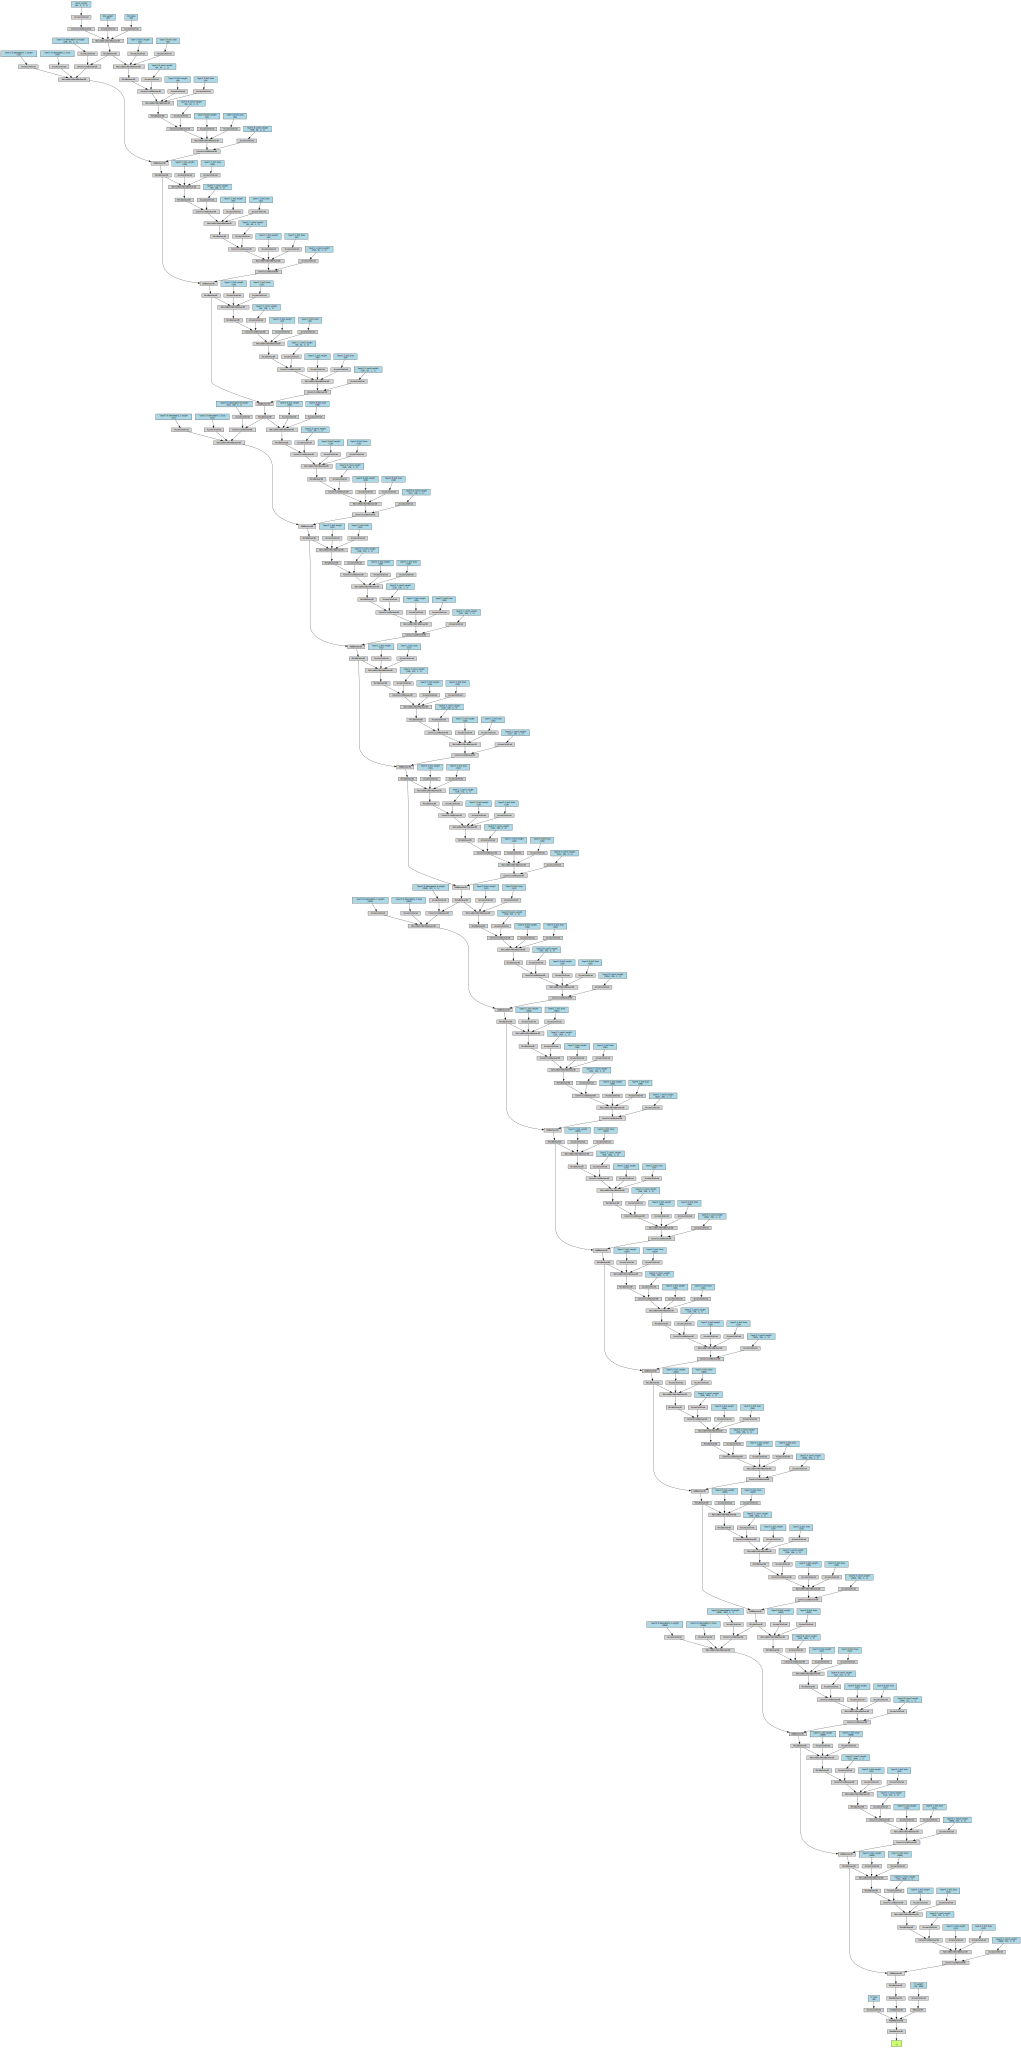

In [10]:
torchviz.make_dot(y.mean(), params=dict(resnet.named_parameters()))

In [7]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.001)

resnet.to(device)

# Initialize variables for tracking best validation loss and accuracy
best_val_loss = float('inf')
best_val_acc = 0.0

# Train the ResNet model
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training phase
    resnet.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # Mixed precision
        with torch.cuda.amp.autocast(enabled=True):
            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

        # Scales loss and calls backward() to create scaled gradients
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params
        scaler.step(optimizer)

        # Updates the scale for next iteration
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        if i % 200 == 199:
            print('[Epoch %d, Iteration %5d] Training Loss: %.3f' % (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    # Validation phase
    resnet.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for data in test_dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = resnet(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    # Calculate metrics
    train_loss = running_loss / len(train_dataloader)
    train_acc = correct / total
    val_loss /= len(test_dataloader)
    val_acc = val_correct / val_total

    # Print and log metrics
    print('[Epoch %d] Training Loss: %.3f, Training Accuracy: %.3f, Validation Loss: %.3f, Validation Accuracy: %.3f' % (epoch + 1, train_loss, train_acc, val_loss, val_acc))

    # Save the model if it has the best validation loss or accuracy
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(resnet.state_dict(), './model/best_model_loss.pth')
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(resnet.state_dict(), './model/best_model_acc.pth')

print('Finished Training')

[Epoch 1, Iteration   200] Training Loss: 2.228
[Epoch 1, Iteration   400] Training Loss: 1.910
[Epoch 1] Training Loss: 0.270, Training Accuracy: 0.238, Validation Loss: 1.753, Validation Accuracy: 0.333
[Epoch 2, Iteration   200] Training Loss: 1.751
[Epoch 2, Iteration   400] Training Loss: 1.724
[Epoch 2] Training Loss: 0.248, Training Accuracy: 0.337, Validation Loss: 2.129, Validation Accuracy: 0.285
[Epoch 3, Iteration   200] Training Loss: 1.629
[Epoch 3, Iteration   400] Training Loss: 1.558
[Epoch 3] Training Loss: 0.221, Training Accuracy: 0.408, Validation Loss: 1.669, Validation Accuracy: 0.421
[Epoch 4, Iteration   200] Training Loss: 1.482
[Epoch 4, Iteration   400] Training Loss: 1.460
[Epoch 4] Training Loss: 0.213, Training Accuracy: 0.455, Validation Loss: 1.480, Validation Accuracy: 0.462
[Epoch 5, Iteration   200] Training Loss: 1.414
[Epoch 5, Iteration   400] Training Loss: 1.396
[Epoch 5] Training Loss: 0.201, Training Accuracy: 0.481, Validation Loss: 2.923, Va